In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASETS\new\CP_DATASET_OGplusGA"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 60 # Can be adjusted, often more epochs for fine-tuning
LEARNING_RATE = 1e-5 # Even lower learning rate for fine-tuning

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24007


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19205 | Val samples: 4802


In [5]:
# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = preprocess_input(img) # For MobileNetV3

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

In [6]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === MobileNetV3 Model (Load from Phase 1 and Unfreeze) ===
# Load the model saved from Phase 1
# model = load_model(r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\MobileNetV3_Phase1_CutMix_GridMask.h5")
model = load_model(r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\MobileNetV3_Phase1_aug_noaug.h5")

# Unfreeze all layers of the model for fine-tuning
# You might choose to unfreeze only a portion, e.g., model.layers[-N:]
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05), # Slightly reduced label smoothing
    metrics=['accuracy']
)

In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
# y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
# class_weights = dict(enumerate(class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(len(CLASSES)),
#     y=y_train_int
# )))
# print("✅ Computed class weights:", class_weights)

In [9]:
# === Train ===
print("\nStarting Phase 2 Training (MobileNetV3 - Fine-tuning)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()] # Increased patience for fine-tuning
    # class_weight=class_weights
)


Starting Phase 2 Training (MobileNetV3 - Fine-tuning)...
Epoch 1/60
📉 Learning rate at epoch 1: 0.000010====] - ETA: 0s - loss: 0.5458 - accuracy: 0.8523     
1201/1201 [==============================] - 149s 117ms/step - loss: 0.5458 - accuracy: 0.8523 - val_loss: 0.4494 - val_accuracy: 0.9046
Epoch 2/60
📉 Learning rate at epoch 2: 0.000010==>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.8842  
1201/1201 [==============================] - 140s 116ms/step - loss: 0.4844 - accuracy: 0.8842 - val_loss: 0.4123 - val_accuracy: 0.9161
Epoch 3/60
📉 Learning rate at epoch 3: 0.000010==>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.9023  
1201/1201 [==============================] - 143s 119ms/step - loss: 0.4450 - accuracy: 0.9023 - val_loss: 0.3806 - val_accuracy: 0.9338
Epoch 4/60
📉 Learning rate at epoch 4: 0.000010==>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.9181  
1201/1201 [==============================] - 145s 121ms/step - loss: 0.4118 - accuracy: 0.9181 - val_loss: 0.3535 - val_accuracy: 0.


📊 Evaluating Phase 2 Model...
1/1 [==============================] - 0s 18ms/step

📊 Classification Report (Phase 2):
              precision    recall  f1-score   support

      BLIGHT       1.00      1.00      1.00       724
       BLAST       1.00      1.00      1.00      1354
   BROWNSPOT       1.00      1.00      1.00      1079
     HEALTHY       1.00      1.00      1.00      1645

    accuracy                           1.00      4802
   macro avg       1.00      1.00      1.00      4802
weighted avg       1.00      1.00      1.00      4802



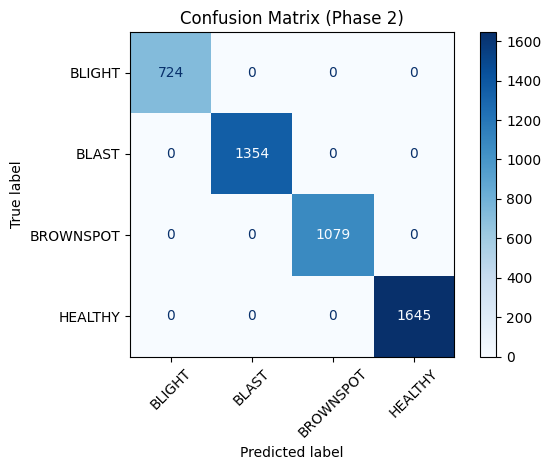

✅ Phase 2 MobileNetV3 Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\MobileNetV3_Phase2_aug_noaug.h5


In [10]:
# === Evaluate ===
print("\n📊 Evaluating Phase 2 Model...")
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report (Phase 2):")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Phase 2)")
plt.tight_layout()
plt.show()

# === Save ===

SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\MobileNetV3_Phase2_aug_noaug.h5"
model.save(SAVE_PATH)
print(f"✅ Phase 2 MobileNetV3 Model saved at: {SAVE_PATH}")